# Analyzing New York High School SAT Results

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests, and whether they're unfair to certain groups. As such, investigating the correlations between SAT scores and demographics might be an interesting angle to take. We could correlate SAT scores with factors like race, gender, income, and more.

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the data set for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

## Reading the Datasets

I will be using 8 datasets in this project:

-  [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)

-  [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school

-  [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school

-  [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information

-  [High School directory](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2) - Directory of high schools in New York City

-  [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City

-  [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school


In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d
    
print(data["sat_results"].head())

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort = False)

print(survey.columns)

Index(['dbn', 'bn', 'schoolname', 'd75', 'studentssurveyed', 'highschool',
       'schooltype', 'rr_s', 'rr_t', 'rr_p',
       ...
       's_q14_2', 's_q14_3', 's_q14_4', 's_q14_5', 's_q14_6', 's_q14_7',
       's_q14_8', 's_q14_9', 's_q14_10', 's_q14_11'],
      dtype='object', length=2773)


The survey dataframe seems to have more that 2000 columns available for us to analyze. We have to filter out the ones we dont need. Luckily there's a [dictionary](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) that explains what each columns are for. 

Based on the dictionary, I picked out several columns that I think relevant on analyzing students SAT Scores.

I also renamed the "dbn" column into "DBN" so it can be merged with the SAT dataset.

In [3]:
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

In [4]:
for key in data:
    print(key)
    print(data[key].head())
    print()

ap_2010
      DBN                             SchoolName  AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.             39.0   
1  01M450                 EAST SIDE COMMUNITY HS             19.0   
2  01M515                    LOWER EASTSIDE PREP             24.0   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH            255.0   
4  02M296  High School of Hospitality Management              NaN   

   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               49.0                                  10.0  
1               21.0                                   NaN  
2               26.0                                  24.0  
3              377.0                                 191.0  
4                NaN                                   NaN  

class_size
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto 

## Preparing the data

After observing the available columns in the dataset, we can see that some do not have the DBN column like the hs_directory and class_size.

For the hs_directory dataset, we can just create a DBN column from the existing cbn column.

The class_size does not seem to have a dbn column though. However, we can see that the DBN column whether from the sat_results or hs_directory dataset is just a combination of the CSD and SCHOOL CODE columns in the class_size data. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. That means we'll need to add a leading 0 to the CSD if the CSD is less than two digits long.

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# Convert number into string, padding it into a fixed length of 2. Example : input "1" will be converted into "01" whereas input "11" will be left as it is
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].map(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

We can also see on the sat_results dataset that the SAT scores are divided into three columns. To make our analysis easier, it might be wise to just combine those three columns into just one, which is the total SAT score.

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]


Next, I want to parse the latitude and longitude coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. 

In [7]:
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condensing the datasets

Now I want to combine the datasets into one dataframe, but it seems I found a problem. If ww look into the class_size dataset, we can see that the DBN column is not unique. This is normal of course, since the dataset stores the information of every classroom that belong in each school. But, this means we cannot just merge the class_size dataset with other dataset using DBN as the key; at least for now.

As a solution, I will condense the class_size dataset so that the DBN value is unique for each row. I will also do this to the graduation and demographics dataset


In [8]:
# We are only concerned with high schools so the GRADE should be 09-12, and GEN ED is picked because its the largest program category.
class_size = data["class_size"]
fltr = (class_size["GRADE "] == "09-12") & (class_size["PROGRAM TYPE"] == "GEN ED")
class_size = class_size[fltr]

#At this point, the DBN values are yet to be unique. So I group and aggregate them based on the DBN values.
class_size = class_size.groupby("DBN")
class_size = class_size.agg(numpy.mean)
class_size = class_size.reset_index()
data["class_size"] = class_size

#We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data.
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [9]:
fltr = data["graduation"]["Cohort"] == "2006"
data["graduation"] = data["graduation"][fltr]
fltr = data["graduation"]["Demographic"] == "Total Cohort"
data["graduation"] = data["graduation"][fltr]

I also need to change some columns on the ap_2010 dataset so they become numerical data.

In [10]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combining the dataset

Now, I will merge the dataset using DBN values as its key. Some will use left join, and some will use inner join.

In [11]:
combined = data["sat_results"]
combined = pd.merge(left = combined, right = data["ap_2010"], on = "DBN", how = "left")
combined = pd.merge(left = combined, right = data["graduation"], on = "DBN", how = "left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# Fill missing data with zeroes if the column does not have a mean
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

I create a new column named "school_dist" to show the code of the school district, which can be retrieved from the first 2 number on the DBN value.

In [12]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].map(get_first_two_chars)

## Finding Correlation

In [13]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations = correlations.sort_values(ascending = False)
print(correlations)

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Total Regents - % of cohort             0.667603
white_per                               0.620718
Total Grads - % of cohort               0.584234
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Total Regents - % of grads              0.494732
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num          

total_enrollment has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.

## Plotting Survey Correlations

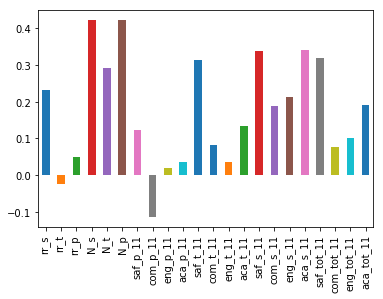

In [14]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

We can see that there are high correlations betweet `N_s`, `N_t` and `N_p` and `sat_score`. But this is to be expected since those columns correlate with total_enrollment.

What interesting is the `rr_s`, the students response rate which is the percentage of students who participated in the survey seems to correlate positively with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

Another thing that seems to correlate with `sat_score` is how the students and teachers perceived safety (`saf_s_11` & `saf_t_11`) in the environment. This makes sense because an unsafe environment would generally be bad for anyone to do anything.

The last interesting correlation is `aca_s_11` which is how students perceive academics standard. However, how the parents and teachers perceive academics standard (`aca_p_11` & `aca_t_11`) dont seem to correlate with `sat_score`.

## Exploring Safety

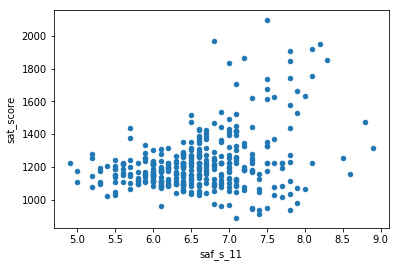

In [15]:
combined.plot.scatter("saf_s_11", "sat_score")


There appears to be a correlation between SAT scores and safety, although it isn't that strong. There are a few schools with extremely high SAT scores and high safety scores. There are also a few schools with low safety scores and low SAT scores. But we can see that no school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

## Racial Differences in Scores

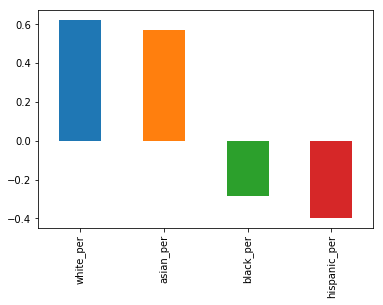

In [16]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][races].plot.bar()

We can see that white and asians students tend to possitively correlate with higher sat scores, whereas a percentage of black and hispanic students correlate negatively with sat scores. This may be due to lack of funding on some schools with high percentage of black and hispanic students.

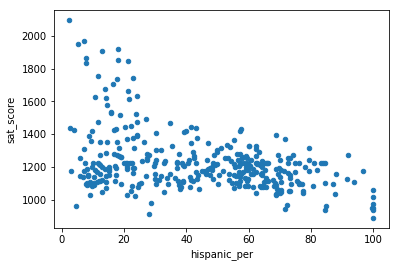

In [17]:
combined.plot.scatter("hispanic_per", "sat_score")

In [18]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Schools listed above are primarily geared towards recent immigrants in the US. This might explain the low SAT scores since most of the students would be still learning english.

In [19]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools above appear to be specialized in science and technology, and only accepts students that passed the examination tests. This does not explain the low percentage of hyspanic student, but it does explain why those schools have good average SAT scores.

## Gender differences in SAT scores

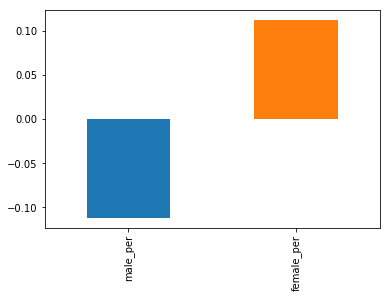

In [20]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

We can see above that high male student percentage correlates negatively with sat scores, whereas high female students percentage correlates positively. Neither correlates strongly, however.

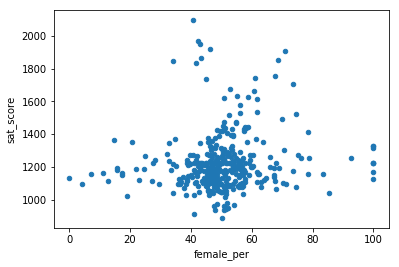

In [21]:
combined.plot.scatter("female_per", "sat_score")

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [22]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

## Class Size and SAT Scores

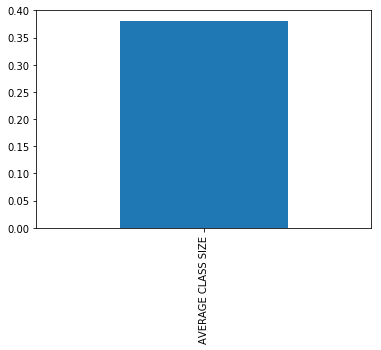

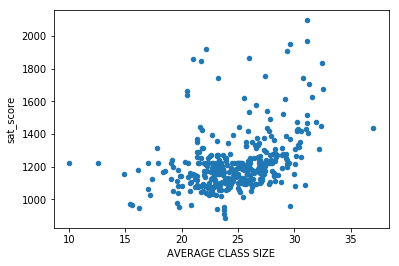

In [23]:
combined.corr()["sat_score"][["AVERAGE CLASS SIZE"]].plot.bar()
combined.plot.scatter("AVERAGE CLASS SIZE", "sat_score")

While average class size seems to positively correlate with SAT scores, the correlation is not that strong. On any average class size, their average SAT scores would mostly place under 1500. For those with high SAT scores above 1500, the reason could be attributed to schools with already high funding with high academic standards. 

In [24]:
print(combined[(combined["AVERAGE CLASS SIZE"] > 30) & (combined["sat_score"] > 1500)][["SCHOOL NAME", "sat_score", "AVERAGE CLASS SIZE"]])

                                           SCHOOL NAME  sat_score  \
24         N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES     1677.0   
37                              STUYVESANT HIGH SCHOOL     2096.0   
60                                  BEACON HIGH SCHOOL     1744.0   
61   FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...     1707.0   
151                       BRONX HIGH SCHOOL OF SCIENCE     1969.0   
187                     BROOKLYN TECHNICAL HIGH SCHOOL     1833.0   
278     LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES     1627.0   
304                    BENJAMIN N. CARDOZO HIGH SCHOOL     1514.0   

     AVERAGE CLASS SIZE  
24            32.566667  
37            31.115789  
60            30.783333  
61            31.306250  
151           31.163158  
187           32.452632  
278           31.582353  
304           31.105263  


If we look at the schools with high SAT scores and high number of students per class, the schools appear to be the top ranking high schools in the U.S. 

## Summary 

So far, few of the factors that could contribute to high SAT scores would be how the teachers and students perception of the safety of their environment. A bad neighborhood would generally be bad for education.

Another factor would be how schools with high percentages of minorities like black and hispanic seems to score lower SAT scores. In this case however, such things could be attributed to bad and poor neighborhood. Other than that, schools with high percentage of hyspanics are usually schools for immigrant where most of the students are not yet fluent in english, so naturally they would score lower in SAT's compared to schools predominantly filled with caucasian or asians.